1. env_core
2. model

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib notebook

In [2]:
from env import EnvCoreTestTradeWithSpread, EnvCoreTestTradeWaitHoldReward

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Flatten, Conv1D, MaxPool1D, Concatenate, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.models import load_model

In [4]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

## dataset

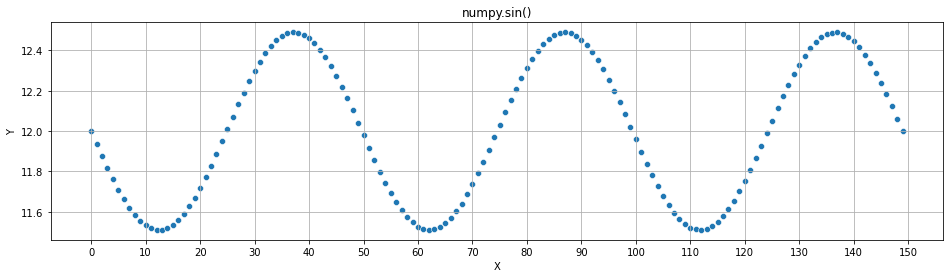

In [5]:
np.random.seed(RANDOM_SEED)

n_periods = 3
n_period_points = 50
scale = 0.7
bias = 12

error_low=0.0
error_hi=0.0

n_points = n_period_points * n_periods

in_array = np.linspace(-(n_periods) * np.pi, (n_periods) * np.pi, n_points)
dataset = np.sin(in_array) * scale
dataset = dataset + np.random.uniform(low=error_low, high=error_hi, size=(n_points,))
dataset = dataset * scale + bias

fig, ax = plt.subplots(figsize=(16, 4))
ax.set_title("numpy.sin()") 
ax.set_xlabel("X") 
ax.set_ylabel("Y") 
ax.grid()

major_ticks = np.arange(0, len(dataset)+1, 10)
ax.set_xticks(major_ticks)

ax = sns.scatterplot(x=range(len(dataset)), y=dataset, ax=ax)




## core

In [6]:
offset = 9
env_core = EnvCoreTestTradeWithSpread(dataset, offset, penalty=-2, reward=0)

In [7]:
class EnvCore(EnvCoreTestTradeWithSpread, EnvCoreTestTradeWaitHoldReward):
    pass

offset = 9
env_core = EnvCore(dataset, offset, penalty=-2, reward=0)

## model

In [8]:
model = tf.keras.models.load_model('model_111')
#model_target = tf.keras.models.load_model('model_spread_target')

In [9]:
model.compile()
#model_target.compile()

In [10]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 3, 32)        544         input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 1, 64)        6208        conv1d_8[0][0]                   
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 1)]          0                                            
_______________________________________________________________________________________

## test run

In [11]:
observation = env_core.reset()

In [12]:
observation

[array([False]),
 array([[0.38505721, 0.        ],
        [0.33155404, 0.        ],
        [0.27890599, 0.        ],
        [0.22795453, 0.        ],
        [0.17951399, 0.        ],
        [0.13435859, 0.        ],
        [0.09321003, 0.        ],
        [0.05672598, 0.        ],
        [0.02548956, 0.        ],
        [0.        , 0.        ]])]

In [13]:
observation, done = env_core.get_observation()

In [14]:
obs2 = [tf.expand_dims(tf.convert_to_tensor(obs),0) for obs in observation]

In [15]:
action = model_target.predict(obs2)
print(action.argmax())

NameError: name 'model_target' is not defined

In [ ]:
reward, info = env_core.apply_action(action.argmax())
print(reward)

In [ ]:
done = False
observation = env_core.reset()

while not done:
    obs2 = [tf.expand_dims(tf.convert_to_tensor(obs),0) for obs in observation]
    action = model.predict(obs2)
    reward, info = env_core.apply_action(action.argmax())
    observation, done = env_core.get_observation()

In [ ]:
env_core.get_metrics()

In [294]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.patches as mpatches

%matplotlib notebook

<IPython.core.display.Javascript object>


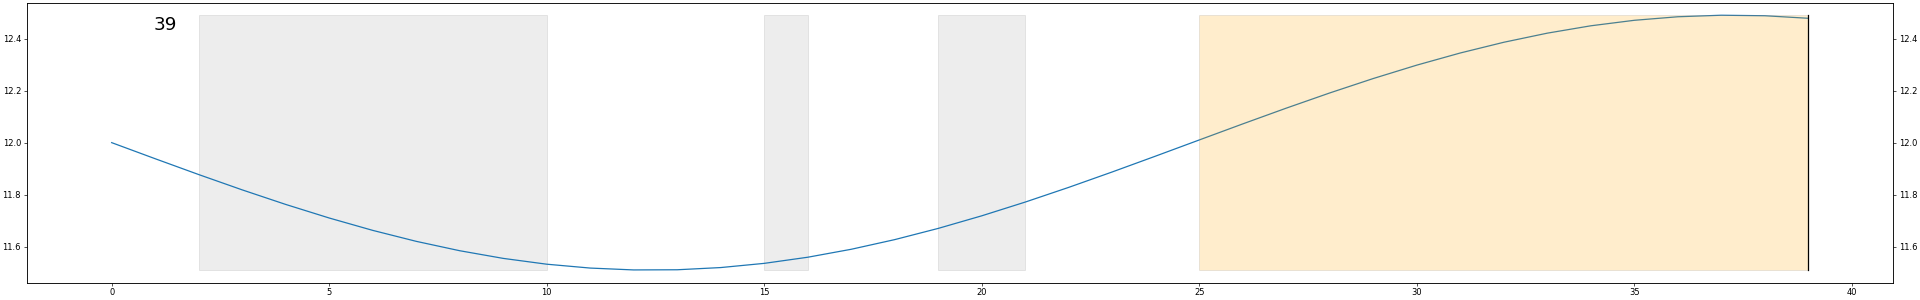

In [376]:
class Renderer:
    FIG_SIZE_X = 32
    FIG_SIZE_Y = 5
    DPI = 30

    def __init__(self, dataset):
        self.dataset = dataset
        self.index = np.arange(len(self.dataset))
        self.openTrade = []
        
        plt.ion()
        
        self.zone = {
            "top": max(self.dataset),
            "bottom": min(self.dataset)
        }
        
        self.height = self.zone["top"] - self.zone["bottom"]
        width = 0
        left_bottom = [0., self.zone["bottom"]]
        self.tradePatch = mpatches.Rectangle(left_bottom, width, self.height, fill=True,
                                             alpha=0.2, color="orange", linewidth=1, ec='grey', visible=False)

        # majing axes
        self.fig, self.ax = plt.subplots(figsize=(self.FIG_SIZE_X, self.FIG_SIZE_Y),
                                         dpi=self.DPI, constrained_layout=True)
        self.ax_d = self.ax.twinx()

        # plotting main figures
        self.ax.plot(self.index, self.dataset)
        self.dyn_plot = self.ax_d.plot([0, 0], (self.zone["bottom"], self.zone["top"]), color='black')
        self.ax_d.add_patch(self.tradePatch)
        self.annotate = self.ax.annotate("", (0.08, 0.9), xycoords='figure fraction', size=22)

        self.fig.canvas.draw()

    def update(self, cursor, action, text=""):
        self.dyn_plot[0].set_xdata([cursor, cursor])
        self.annotate.set_text(text)

        if action == 0:
            pass

        elif action == 1:
            if not len(self.openTrade):
                self.openTrade = [cursor, self.zone["bottom"]]
                width = cursor - self.openTrade[0]

                self.tradePatch.set_xy(self.openTrade)
                self.tradePatch.set_width(width)

                self.tradePatch.set_visible(True)
            else:
                # bad action
                pass


        elif action == 2:
            width = cursor - self.openTrade[0]
            self.tradePatch.set_width(width)


        elif action == 3:
            # пока подождем
            self.tradePatch.set_visible(False)

            width = cursor - self.openTrade[0]
            rect = mpatches.Rectangle(self.openTrade, width, self.height, fill=True,
                                      alpha=0.2, color="darkgrey", linewidth=1, ec='grey')

            self.ax.add_patch(rect)

            self.openTrade = []
            pass

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        
        
s = [0,0,1,2,2,2,2,2,2,2,3,0,0,0,0,1,3,0,0,1,2,3,0,0,0,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,]
r = Renderer(dataset[:40])



In [377]:
for i in range(len(dataset[:40])):
    r.update(i, s[i], text=i)

1. Торговые операци показываем как прямоугольники
2. Неверные действия показываем определенным цветом - не контрастно, но выделяем особым уветом


In [28]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.patches as mpatches

%matplotlib notebook

<IPython.core.display.Javascript object>


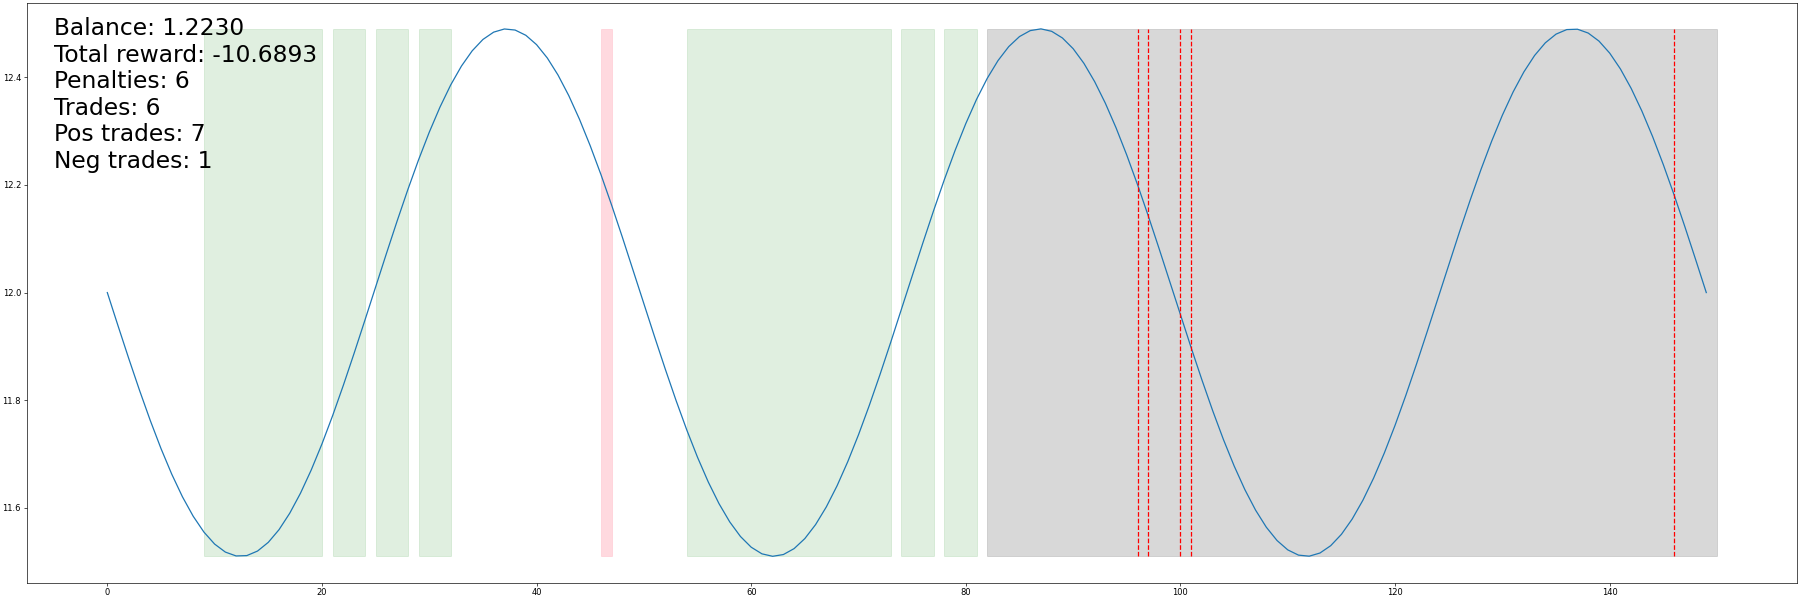

In [83]:
class Player:
    PLOT_X = 30
    PLOT_Y = 10
    DPI = 30
    def __init__(self, env_core, model):
        self.env_core = env_core
        self.model = model
        
        self.fig, self.ax = plt.subplots(figsize=(self.PLOT_X, self.PLOT_Y), dpi=self.DPI, constrained_layout=True)
        self.ax.plot(np.arange(len(self.env_core.dataset)), self.env_core.dataset)


       
        
    def play(self):
        done, done_ = False, False
        observation = self.env_core.reset()

        while not done:
            done = done_
            obs_transformed = [tf.expand_dims(tf.convert_to_tensor(obs),0) for obs in observation]
            action = self.model.predict(obs_transformed)
            reward, info = self.env_core.apply_action(action.argmax())
            balance = self.env_core.get_metric("Balance")
            
            #self.update(self.env_core.cursor, action.argmax(), "Balance: {0:.4f}".format(balance))
            
            observation, done = self.env_core.get_observation()

        self.render()
        return self.env_core.metrics
    
    def render(self):
        
        txt = self.get_message()
        self.ax.annotate(txt, (0.03, 0.72), xycoords='figure fraction', size=28)
        

        y_min = min(self.env_core.dataset)
        y_max = max(self.env_core.dataset)

        trades = self.env_core.get_trades_history()
        for trade in trades:

            height = y_max - y_min
            left_bottom = (trade.cursor_open, y_min)
            if trade.cursor_close == None:
                width = len(dataset) - trade.cursor_open
                color="grey"
                alpha=0.3
            else:
                width = trade.cursor_close - trade.cursor_open
                if trade.profit<0:
                    color="pink"
                    alpha = 0.6
                else:
                    color="green"
                    alpha=0.12

            rect = mpatches.Rectangle(left_bottom, width, height, fill=True,
                                              alpha=alpha, color=color, linewidth=1)

            self.ax.add_patch(rect)
        
        bad_actions = self.env_core.get_bad_actions_history()
        for bad_action in bad_actions:
            self.ax.plot((bad_action["cursor"], bad_action["cursor"]), (y_min, y_max),color='red',linestyle='dashed')
            
            
        
                
    def get_message(self):
        msg = "Balance: {Balance:.4f} \n" \
            "Total reward: {TotalReward:.4f} \n" \
            "Penalties: {Penalties} \n" \
            "Trades: {Penalties} \n" \
            "Pos trades: {PosTrades} \n" \
            "Neg trades: {NegTrades}" 
        msg = msg.format(**self.env_core.metrics)
        return msg
        
                
                


play_test = Player(env_core, model)
        
            

In [84]:
results = play_test.play()

In [33]:
results

{'Balance': 1.2229629118905239,
 'Penalties': 6,
 'Trades': 8,
 'Rewards': 0,
 'TotalReward': -10.689301983059764,
 'PosTrades': 7,
 'NegTrades': 1}

## Требования к отображению 
1. Показываем график датасета сразу
2. По мере продвижения по датасету рендерим текущую точку - на каждом шаге получаем координаты текущей точки.
3. Показываем торговые операции - полупрозначным прямоугольником. Правая его зона расширяется до момента продажи.
4. При продаже фиксируе

алгоритм